# Parameters estimates: MAP and mean

In this demo, we build a data set with a wide posterior, and show how to select the estimate type.

In `psignifit`, there are two estimate type:
- with `MAP` (Maximum A Posteriori), the parameters are estimated as the mode of the posterior. This is the default estimate type.
- with `mean`, the parameters are estimated as the mean of the posterior


In [1]:
import warnings

from matplotlib import pyplot as plt
import numpy as np

import psignifit
import psignifit.psigniplot as psp
from psignifit import sigmoids

We generate data from a mixture of three sigmoids with different width, with
only a few trials. The posterior over width is broad and asymmetrical, so the
MAP and mean estimate are not identical.

In [4]:
# Parameters of the sigmoids and data generation
stim_range = [0.001, 0.001 + 10 * 1.1]
lambda_ = 0.0232
gamma = 0.1

widths = [1.1, 3.1, 6.3]
threshold = stim_range[1] / 2

sigmoid = sigmoids.Gaussian()
num_trials = 3
nsteps = 20
stimulus_level = np.linspace(stim_range[0], stim_range[1], nsteps)


Using the `tools.psychometric` we can simulate percent correct values for each stimulus level

In [5]:
perccorr1 = sigmoid(stimulus_level, threshold, widths[0], gamma, lambda_)
perccorr2 = sigmoid(stimulus_level, threshold, widths[1], gamma, lambda_)
perccorr3 = sigmoid(stimulus_level, threshold, widths[2], gamma, lambda_)
perccorr = np.concatenate((perccorr1, perccorr2, perccorr3))
levels = np.concatenate((stimulus_level, stimulus_level, stimulus_level))

We construct our data array

In [6]:
random_state = np.random.RandomState(883)

ntrials = np.ones(nsteps * 3, dtype=int) * num_trials
hits = random_state.binomial(ntrials, perccorr)

levels = np.concatenate((stimulus_level, stimulus_level, stimulus_level))
data = np.dstack([levels, hits, ntrials]).squeeze()


This is what the data looks like -- as you can see, the data could be compatible with a wide range of psychometric functions. This means that the posterior distribution over parameters is going to be wide.

Text(0, 0.5, 'Hits')

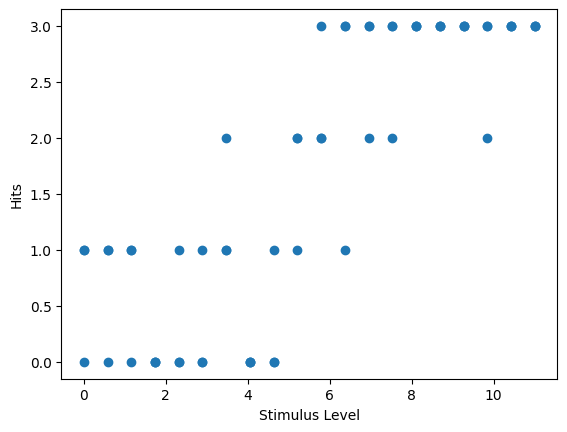

In [7]:
fig, ax = plt.subplots()
ax.scatter(levels, hits)
ax.set_xlabel("Stimulus Level")
ax.set_ylabel("Hits")

We set the options for our fit. In this case we assume a yes/no experiment and we want to estimate all parameters (i.e. fix none).

We can set at this point the `estimate_type` to `'MAP'` or '`mean`'. This sets the default estimate type to use in all `psignifit` methods and plots. This default value can be overwritten later using the `estimate_type` optional argument.

In [8]:
options = {
    'sigmoid': sigmoid,
    'experiment_type': 'yes/no',
    'fixed_parameters': {'lambda': 0.0232, 'gamma': 0.1},
    'estimate_type': 'mean', 
}


Now we run the fitting procedure. (We ignore a warnings that is trying to tell us that we have too many stimulus levels.)

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # We set `debug=True` so that we can examing the full posterior over parameters.
    result = psignifit.psignifit(data, debug=True, **options)

Let's have a look at the results, starting from the posterior distribution over parameters.

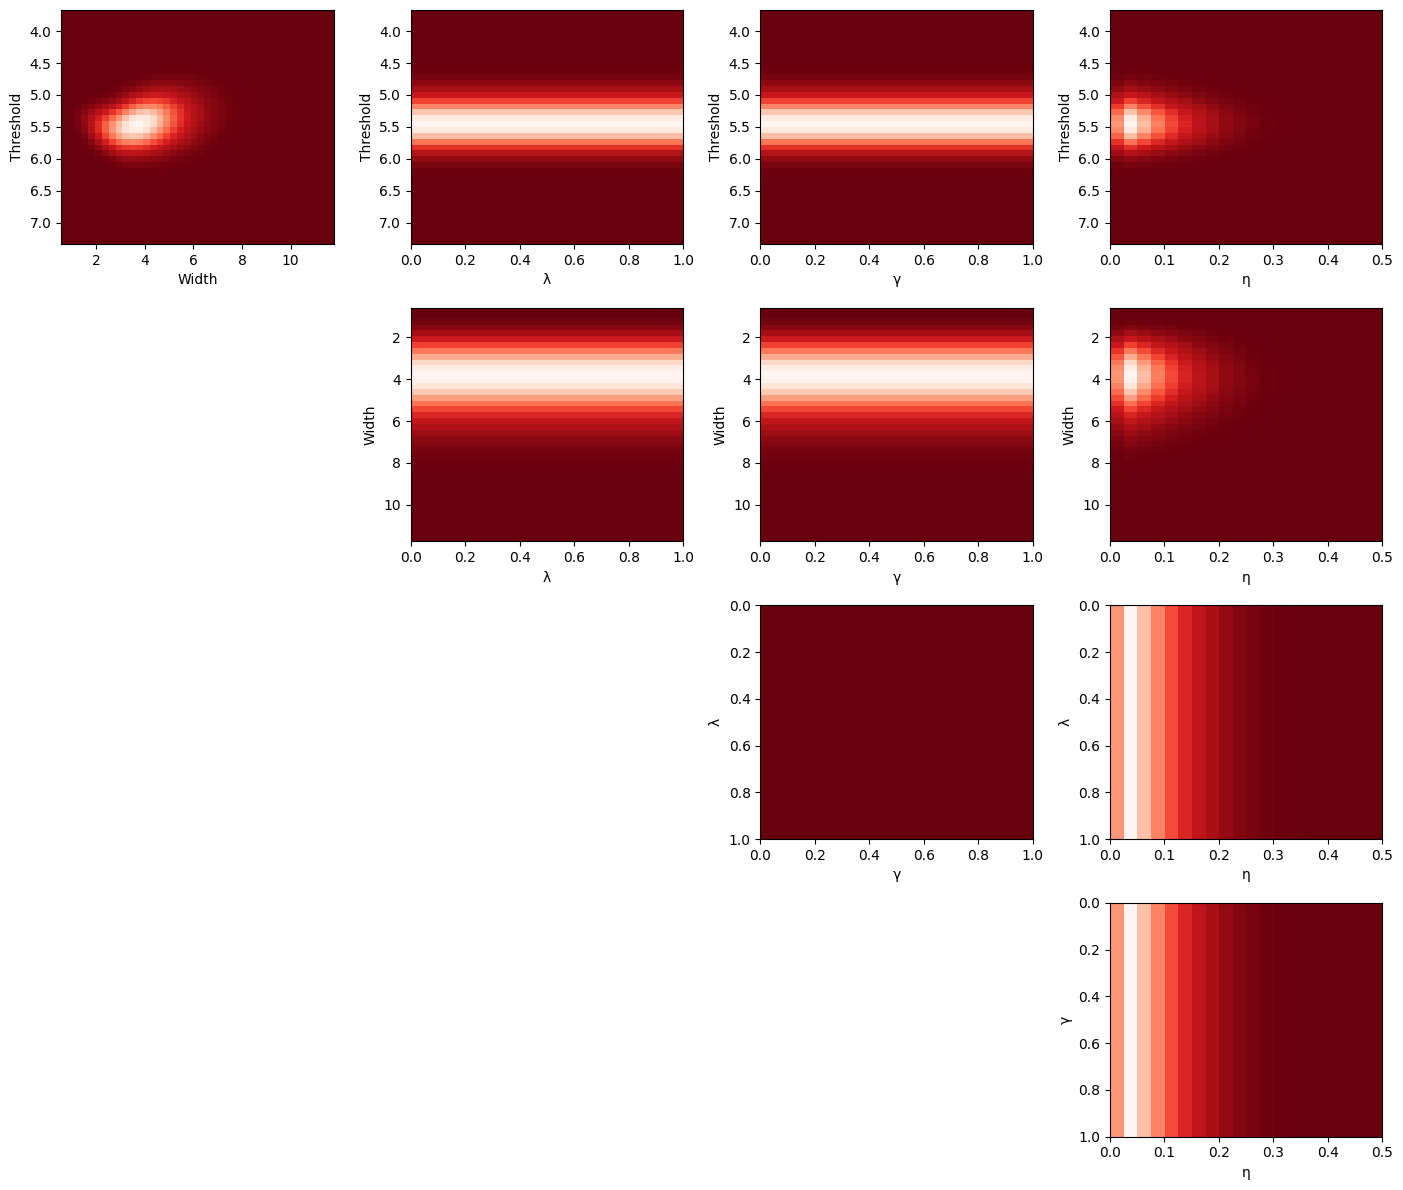

In [10]:
psp.plot_bayes(result);

As you can see, the posterior is quite broad and asymmetrical, and we expect the mean and MAP estimates to be slightly different. We can ask `Result` for both estimate.

In [11]:
# This gives the default estimate, in this case the mean estimate since we set it in the options.
result.parameter_estimate  

{'eta': np.float64(0.07274831038039509),
 'gamma': np.float64(0.09999999999999998),
 'lambda': np.float64(0.023199999999999995),
 'threshold': np.float64(5.429846600944022),
 'width': np.float64(4.027280086833293)}

In [12]:
# We can overwrite the default setting by specifying the `estimate_type` parameter in the method get_parameter_estimate
result.get_parameter_estimate(estimate_type='MAP')  

{'gamma': np.float64(0.1),
 'lambda': np.float64(0.0232),
 'eta': np.float64(1.0160031566292985e-08),
 'threshold': np.float64(5.459454390045572),
 'width': np.float64(3.679911898980962)}

Looking at the estimated parameters, we see that the estimate of `width` is slightly different in the two cases. 
In `psigniplot`, we can choose which one to visualize.

<Axes: xlabel='Width', ylabel='Marginal Density'>

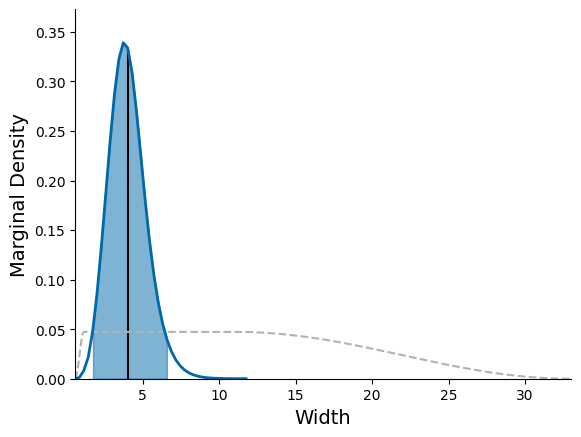

In [13]:
# Uses the default, in this case `'mean'`
psp.plot_marginal(result, 'width')  

<Axes: xlabel='Width', ylabel='Marginal Density'>

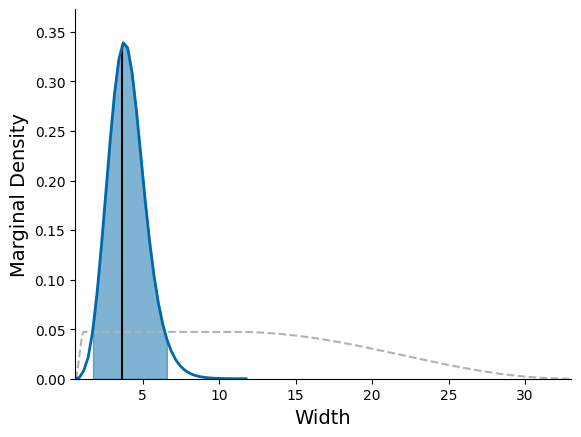

In [14]:
# Overwrites the default, uses `'MAP'`
psp.plot_marginal(result, 'width', estimate_type='MAP')

It works the same way for every other `psignifit` functionality involving the estimates. For example, we can visualize the psychometric function for both estimates, although the difference is almost imperceptible in this case (we superimpose the two plots so you can appreciate it ;-) ).

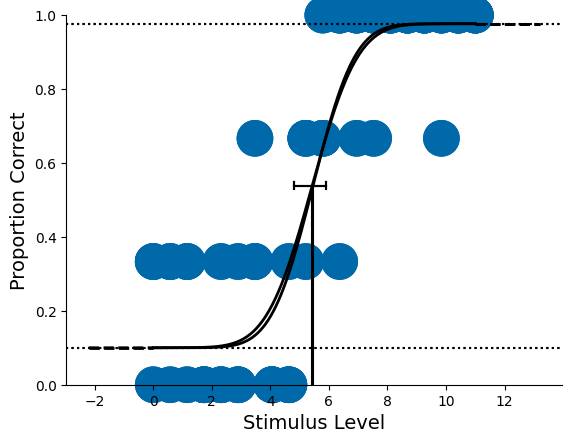

In [15]:
ax = psp.plot_psychometric_function(result, estimate_type='mean');
psp.plot_psychometric_function(result, estimate_type='MAP', ax=ax);
